In [10]:
using Distributions
using Random
using Plots
using PyPlot
using StatsBase

# AVI-Suite

AVI-Suite provides the necessary functions for uniformised AVI, continuous time AVI, evaluation via simulation, and exact evaluation via DP, all in one place. This provides a flexible testbed for testing all four of the AVI algorithms, and ensures that all functions are named such that their purpose is clear, and there is no confusion between similar functions.

Sections:

-[Miscellaneous Functions](#Miscellaneous-Functions)

-[Pre-requisite functions for uniformised AVI](#Pre-requisite-functions-for-uniformised-AVI)

-[Uniformised AVI functions](#Uniformised-AVI-functions)

-[Pre-requisite functions for continuous time AVI](#Pre-requisite-functions-for-continuous-time-AVI)

-[Continuous time AVI Functions](#Continuous-time-AVI-Functions)

-[Pre-requisite Functions for Exact DP on Homogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Homogeneous-Problems)

-[Exact DP on Homogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Homogeneous-problem)

-[Pre-requisite Functions for Exact DP on Inhomogeneous Problems](#Pre-requisite-Functions-for-Exact-DP-on-Inhomogeneous-Problems)

-[Exact DP on Inhomogeneous Problems (RVIA and PE/PI)](#Exact-DP-for-Inhomogeneous-Problem-(using-exact-h-or-VFA))

-[Evaluation via simulation](#Evaluation-via-simulation)

-[APE on Fully Active Policy](#APE-on-Fully-Active-Policy)

-[APE using a given VFA](#APE-using-a-given-VFA)

# Miscellaneous Functions

-Functions for enumerating state and action spaces

-Functions for calculating flows given a state or state-action pair

-Function for evaluating a VFA at a given state

In [11]:
#produce an array of array representations of all possible states
function enumerateStates(N::Int64)
    if N==1
        return [[1],[2],[3]]
    end
    
    output = []
    lower = enumerateStates(N-1)
    for s in lower
        new1 = append!([1],s)
        new2 = append!([2],s)
        new3 = append!([3],s)
        append!(output,[new1])
        append!(output,[new2])
        append!(output,[new3])
    end
    
    return output
end

#produce an array of array representations of all possible actions
function enumerateActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = []
    lower = enumerateActions(N-1)
    for a in lower
        new1 = append!([0],a)
        new2 = append!([1],a)
        append!(output,[new1])
        append!(output,[new2])
    end
    
    return output
end    

#produce array of array representations of all restricted, or single-repair, actions
function enumerateRestrictedActions(N::Int64)
    if N==1
        return [[0],[1]]
    end
    
    output = [zeros(Int64,N)]
    for i in 1:N
        temp = zeros(N)
        temp[i] = 1
        append!(output,[temp])
    end
    
    return output
end

#convert all array elements to string, then concatanate all elements (DEPRECATED AS DICTS CAN TAKE ARRAYS AS KEYS)
function arrayToString(x)
    return join(string.(x))
end

arrayToString (generic function with 1 method)

In [12]:
#function for calculating the flows given a state
function calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    #update flows
    flows = zeros(N)
    healthy = sum(i == 1 for i in s)
    
    #if no links are healthy, return 
    if healthy == 0
        return flows, c1
    end
    
    #otherwise, find best route, and return
    bestCost = maximum(c0) + 1
    usedLink = 0
    for k in 1:N
        if s[k] == 1 && c0[k] < bestCost
            bestCost = c0[k]
            usedLink = k
        end
    end
    
    flows[usedLink] = beta
    
    return flows, bestCost
end

#function for calculating the flows given a state-action pair
function calculateFlows(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    sPrime = s - a
    return calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
end

calculateFlows (generic function with 2 methods)

In [13]:
#evaluate a VFA at a given state
function v(s, params, features)
    numFeatures = length(features)
    return params[1] + sum(params[i+1]*features[i](s) for i in 1:numFeatures)
end

v (generic function with 1 method)

# Pre-requisite functions for uniformised AVI

In [14]:
#Given a state-action pair, return the next random pre-decision state, the instant cost, and the updated flows
function updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #observe exogenous information
    w = rand(Uniform(0, 1))
    
    #interpret exog info: is it a demand deg, rare deg, or completed repair 
    found = false
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        if runningTotal <= w <= runningTotal + flows[k]*alpha_d[k]*del
            found = true
            sPrime[k] = 3
            #println("Demand Deg at "*string.(k))
            break
        end
        runningTotal = runningTotal + flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    if found == false
        for k in 1:N
            if runningTotal <= w <= runningTotal + alpha_r[k]*del
                found = true
                sPrime[k] = 3
                #println("Rare Deg at "*string.(k))
                break
            end
            runningTotal = runningTotal + alpha_r[k]*del
        end
    end
    
    #repairs
    if found == false && repair > 0
        if runningTotal <= w <= runningTotal + tau(repair)*del
            found = true
            #find all repairing links
            repairing = []
            for k in 1:N
                if sPrime[k] == 2
                    append!(repairing,[k])
                end
            end
            repaired = sample(repairing)
            sPrime[repaired] = 1
            #println("Repair completed at "*string.(repaired))
        end
    end
    
    if found == false
        #println("No Event")
    end
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    healthy = sum(i == 1 for i in sPrime)
    
    return sPrime, (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del, newFlows
end

updateStateAndFlowsUnif (generic function with 1 method)

In [15]:
#instant cost over the timestep
function instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    sPrime = s - a
    healthy = sum(sPrime[i] == 1 for i in 1:N)
    repair = sum(sPrime[i] == 2 for i in 1:N)
    damaged = sum(sPrime[i] == 3 for i in 1:N)
    
    #update flows
    flowUpdate = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    newFlows = flowUpdate[1]
    bestCost = flowUpdate[2]
    
    return (beta*bestCost + sum(r[k]*(sPrime[k]==2) for k in 1:N))*del
end

instantCostUnif (generic function with 1 method)

In [16]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h. Also used in Exact PE/PI when using a VFA
#One version takes flows as an argument, the other calculates the flows
function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

function expectedNextValueUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, vParams, features)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    flows = calculateFlows(sPrime,N,alpha_d, alpha_r, beta, tau, c0, c1, r)[1]
    runningTotal = 0.0
    runningTotalProb = 0.0
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*v(sPrime, vParams, features)
end  

expectedNextValueUnif (generic function with 2 methods)

# Uniformised AVI functions

In [17]:
#Performs AVI in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function approxValueIterationUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            i = sample(1:N)
            optA[i] = 1
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        bestV = max(bestV, 0)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationUnifApprox (generic function with 1 method)

In [18]:
#Performs AVI in uniformised setting, approximating E(h(s')) using all possible transitions
function approxValueIterationUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        optV = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - g
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if forceActive && s == fill(3,N) && optA == zeros(Int64, N)
            i = sample(1:N)
            optA[i] = 1
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        bestV = max(bestV, 0)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationUnifFull (generic function with 1 method)

# Pre-requisite functions for continuous time AVI

In [19]:
#Calculate the expected sojourn time of a state-action pair
function sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    s = s - a
    if s == fill(3,N)
        return 1/(beta*sum(alpha_d) + sum(alpha_r) + tau(N))
    end
    
    numRep = sum(i == 2 for i in s)
    cumulativeRate = 0.0
    for i in 1:N
        if s[i] == 1
            cumulativeRate += flows[i]*alpha_d[i] + alpha_r[i]
        elseif s[i] == 2
            cumulativeRate += alpha_r[i] + tau(numRep)/numRep
        end
    end
    
    return 1/cumulativeRate
end

sojournTime (generic function with 1 method)

In [20]:
#calculate the expected cost accumulated until a transition 
function instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = 0)
    if del == 0
        del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    end
    
    return instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
end

instantCostCont (generic function with 1 method)

In [21]:
#Given a state-action pair, return the next random pre-decision state, the cost accumulated over the sojourn time, and the updated flows
function updateStateAndFlowsCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    actualTime = rand(Exponential(del))
    result = updateStateAndFlowsUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
    return result[1], instantCostCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows; del = actualTime), result[3], actualTime
end

updateStateAndFlowsCont (generic function with 1 method)

In [22]:
#Calculates E(h(s')) given a state-action pair, and a VFA for h
function expectedNextValueCont(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features)
    del = sojournTime(s, a, flows, N, alpha_d, alpha_r, beta, tau)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    #different treatment for all-damaged state
    if sPrime == fill(3,N)
        return v(sPrime,vParams,features)
    end
    
    runningTotal = 0
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*v(sNext, vParams, features)
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*v(sNext, vParams, features)
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*v(sNext, vParams, features)
            end
        end
    end
    
    return runningTotal
end   

expectedNextValueCont (generic function with 1 method)

# Continuous time AVI Functions

In [23]:
#Performs AVI in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function approxValueIterationContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            i = sample(1:N)
            optA[i] = 1
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        bestV = max(bestV, 0)
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContApprox (generic function with 1 method)

In [24]:
#Performs AVI in the continuous time setting, approximating E(h(s')) using all possible transitions
function approxValueIterationContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                
                if vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures) <= optV
                    optV = vParams[1] + sum(vParams[i+1]*features[i](s-a) for i in 1:numFeatures)
                    optA = a
                end
            end
        end
        
        #Fix random link if optA is passive for [3,3,...,3]
        if s == fill(3,N) && optA == zeros(Int64, N)
            i = sample(1:N)
            optA[i] = 1
        end
        
        bestA = optA
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        bestV = max(bestV, 0)
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

approxValueIterationContFull (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Homogeneous Problems 

In [25]:
#instant cost function strictly for homogeneous problem
function instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    
    #if no links are healthy, return 
    if N - i1 - i2 == 0
        return (beta*c1 + r*i2Prime)*del
    end
    
    
    return (beta*c0 + r*i2Prime)*del
end

instantCostHomog (generic function with 1 method)

In [26]:
#calculates E(h(s')) from s,a strictly for a homogeneous problem
function expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    #immediate change
    i1Prime = i1 - a
    i2Prime = i2 + a
    thisH = h[i1+1,i2+1]
    
    #if all are damaged
    if i1Prime == N
        return thisH
    end
    
    #if none are healthy
    if N - i1 - i2 == 0
        return thisH + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH) + i2Prime*del*alpha_r*(h[i1Prime+1+1, i2Prime-1+1] - thisH)
    end
    
    #if none are repairing
    if i2Prime == 0
        return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH)
    end
    
    return thisH + (beta*alpha_d + (N - i1 - i2)*alpha_r)*del*(h[i1Prime+1+1,i2Prime+1] - thisH) + i2Prime*alpha_r*del*(h[i1Prime+1+1,i2Prime-1+1] - thisH) + tau(i2Prime)*del*(h[i1Prime+1,i2Prime-1+1] - thisH)
end

expectedNextValueHomog (generic function with 1 method)

In [27]:
#calculates the exact PI action strictly for a homogeneous problem
function piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        for a in 2:i1
            testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for a in 1:i1
        testH = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomog (generic function with 1 method)

In [28]:
#calculates the approx PI action based on instantaneous approximation, strictly for a homogeneous problem
function piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    if i1 == 0
        return 0
    end
    
    if i1 == N && forceActive
        optA = 1
        optH = h[i1-optA+1,i2+optA+1]
        for a in 2:i1
            testH = h[i1-a+1,i2+a+1]
            if testH <= optH
                optA = a
                optH = testH
            end
        end
        return optA
    end
    
    optA = 0
    optH = instantCostHomog(i1,i2,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) - g*del
    for a in 1:i1
        testH = h[i1-a+1,i2+a+1]
        if testH <= optH
            optA = a
            optH = testH
        end
    end
    
    return optA
end

piActionHomogApprox (generic function with 1 method)

In [29]:
#calculates the exact PI policy strictly for a homogeneous problem
function piPolicyHomog(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomog (generic function with 1 method)

In [30]:
#calculates the approx PI policy based on instantaneous approximation, strictly for a homogeneous problem
function piPolicyHomogApprox(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = false)
    policy = zeros(Int64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            policy[i1+1,i2+1] = piActionHomogApprox(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
        end
    end
    
    return policy
end

piPolicyHomogApprox (generic function with 1 method)

In [31]:
function hFromVFAHomog(N, params, features)
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    return hIn
end

hFromVFAHomog (generic function with 1 method)

# Exact DP for Homogeneous problem

In [32]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rpiHomog(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomog(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomog (generic function with 1 method)

In [33]:
#Evaluates the fully active policy, strictly for a homogeneous problem 
function rpeFAHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = i1
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rpeFAHomog (generic function with 1 method)

In [34]:
#Evaluates an approximate PI policy based on a given exact h function and instananeous actions, strictly for a homogeneous problem 
function rpiHomogApprox(N::Int64, hIn, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    policy = piPolicyHomogApprox(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g; forceActive = forceActive)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = policy[i1+1,i2+1]
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n, policy
end

rpiHomogApprox (generic function with 1 method)

In [35]:
#Evaluates a PI policy based on a given VFA, using instananeous approximation, strictly for a homogeneous problem 
function rpiHomogVFAApprox(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64, g::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomogApprox(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFAApprox (generic function with 1 method)

In [36]:
#Evaluates a PI policy based on a given VFA, strictly for a homogeneous problem 
function rpiHomogVFA(N::Int64, params, features, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    
    #construct hIn table
    hIn = zeros(Float64, N+1, N+1)
    for i1 in 0:N
        for i2 in 0:(N - i1)
            s = fill(1,N)
            if i1 > 0
                for i in 1:i1
                    s[i] = 3
                end
            end
            
            if i2 > 0
                for i in (i1+1):(i1+i2)
                    s[i] = 2
                end
            end
            
            hIn[i1+1,i2+1] = v(s, params, features)
        end
    end
    
    #run standard function
    return rpiHomog(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = nMax, delScale = delScale, forceActive = forceActive)
end

rpiHomogVFA (generic function with 1 method)

In [37]:
#Evaluates a PI policy based on a given exact h function, strictly for a homogeneous problem 
function rviHomog(N::Int64, alpha_d::Float64, alpha_r::Float64, beta::Float64, tau, c0::Float64, c1::Float64, r::Float64, epsilon::Float64; nMax = 0, delScale = 1, forceActive = false)
    #calculate stepsize and initialise h,w,and policy vectors
    del = 1/(delScale*(beta*alpha_d + N*alpha_r + tau(N)))
    h = zeros(Float64, N+1, N+1)
    w = zeros(Float64, N+1, N+1)
    n = 0
    #repeat until epsilion-convergence or n = nMax
    while true
        n = n + 1
        #calculate new w values
        for i1 in 0:N
            for i2 in 0:(N - i1)
                a = piActionHomog(i1, i2, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del; forceActive = forceActive)
                w[i1+1,i2+1] = instantCostHomog(i1,i2,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueHomog(i1,i2, h, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            end
        end
        
        
        #calculate new relative values
        hNew = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:(N - i1)
                hNew[i1+1,i2+1] = w[i1+1,i2+1] - w[1,1]
            end
        end
        
        #check for convergence
        deltas = zeros(Float64, N+1, N+1)
        for i1 in 0:N
            for i2 in 0:N-i1
                deltas[i1+1,i2+1] = hNew[i1+1,i2+1] - h[i1+1,i2+1]
            end
        end
        
        h = hNew
        if maximum(deltas) < epsilon || n == nMax
            break
        end
    end
    
    v = beta*c0*del + (beta*alpha_d + (N)*alpha_r)*del*h[1+1,0+1] + (1 - (beta*alpha_d + (N)*alpha_r)*del)*h[0+1,0+1]
    
    return v/del, h, n
end

rviHomog (generic function with 1 method)

# Pre-requisite Functions for Exact DP on Inhomogeneous Problems

In [38]:
#calculates E(h(s')) from s,a using exact h table
function expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
    #immediate change
    sPrime = s - a
    healthy = sum(i == 1 for i in sPrime)
    repair = sum(i == 2 for i in sPrime)
    damaged = sum(i == 3 for i in sPrime)
    
    runningTotal = 0.0
    runningTotalProb = 0.0
    
    flows = zeros(Float64, N)
    if healthy > 0
        #otherwise, find best route, and return
        bestCost = maximum(c0) + 1
        usedLink = 0
        for k in 1:N
            if sPrime[k] == 1 && c0[k] < bestCost
                bestCost = c0[k]
                usedLink = k
            end 
        end
        
        flows[usedLink] = beta
    end
    
    
    #demand degs
    for k in 1:N
        sNext = copy(sPrime)
        sNext[k] = 3
        runningTotal += flows[k]*alpha_d[k]*del*h[sNext]
        runningTotalProb += flows[k]*alpha_d[k]*del
    end
    
    #rare degs
    for k in 1:N
        if sPrime[k] != 3
            sNext = copy(sPrime)
            sNext[k] = 3
            runningTotal += alpha_r[k]*del*h[sNext]
            runningTotalProb += alpha_r[k]*del
        end
    end
    
    #repairs
    if repair > 0
        for k in 1:N
            if sPrime[k] == 2
                sNext = copy(sPrime)
                sNext[k] = 1
                runningTotal += (tau(repair)/repair)*del*h[sNext]
                runningTotalProb += (tau(repair)/repair)*del
            end
        end
    end
    
    return runningTotal + (1 - runningTotalProb)*h[sPrime]
end 

expectedNextValueExact (generic function with 1 method)

In [39]:
#calculates PI action using exact h table
function piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExact (generic function with 1 method)

In [40]:
#calculates PI action using exact h table, based off instananeous actions
function piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,h) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = h[s-a]
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionExactInstant (generic function with 1 method)

In [41]:
#calculates PI action using a VFA
function piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFA (generic function with 1 method)

In [42]:
#calculates PI action using a VFA and instananeous actions
function piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    if s == fill(1, N)
        return zeros(Int64, N)
    end
    
    optA = zeros(Int64, N)
    optH = instantCostUnif(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueUnif(s, optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del,params,features) - g*del
    for i in 1:N
        if s[i] == 3
            a = zeros(Int64,N)
            a[i] = 1
            testH = v(s-a,params,features)
            if testH < optH
                optA = a
                optH = testH
            end
        end
    end
    return optA
end

piActionVFAInstant (generic function with 1 method)

In [43]:
#calculates PI policy using exact h table
function piPolicyExact(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyExact (generic function with 1 method)

In [44]:
#calculates PI policy using exact h table, interpretting h with instant actions
function piPolicyExactInstant(h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionExactInstant(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyExactInstant (generic function with 1 method)

In [45]:
#calculates PI policy from a VFA
function piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFA(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    end
    
    return policy
end

piPolicyVFA (generic function with 1 method)

In [46]:
#calculates PI policy from a VFA, using instant actions to interpret h
function piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    policy = Dict()
    stateSpace = enumerateStates(N)
    for s in stateSpace
        policy[s] = piActionVFAInstant(s, params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    end
    
    return policy
end

piPolicyVFAInstant (generic function with 1 method)

# Exact DP for Inhomogeneous Problem (using exact h or VFA)

In [47]:
#Performs one round of exact PI and PE using exact h table
function rpiExact(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExact(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rpiExact (generic function with 1 method)

In [48]:
#Performs one round of exact PI and PE using exact h table, using instant actions to interpet h
function rpiExactInstant(N, hIn, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = piPolicyExactInstant(hIn, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiExactInstant (generic function with 1 method)

In [49]:
#Performs exact PE on the fully-active policy
function rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N)
            for i in 1:N
                if s[i] == 3
                    a[i] = 1
                end
            end 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpeFA (generic function with 1 method)

In [50]:
#Performs exact PE on the passive policy
function rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct fully active action
            a = zeros(Int64, N) 
            
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpePassive (generic function with 1 method)

In [51]:
#Performs one round of exact PI and PE using VFA
function rpiVFA(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFA(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFA (generic function with 1 method)

In [52]:
#Performs one round of exact PI and PE using VFA and instantaneous actions to interpret h
function rpiVFAInstant(N, params, features, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon, g; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    policy = piPolicyVFAInstant(params, features, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del, g)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            
            #construct action
            a = policy[s]
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n
end

rpiVFAInstant (generic function with 1 method)

In [53]:
#Performs RVIA
function rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, epsilon; nMax = 0, delScale = 1, printProgress = false, modCounter = 100)
    #calculate stepsize and initialise h,w,and policy dictionaries
    del = 1/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    h = Dict()
    w = Dict()
    policy = Dict()
    stateSpace = enumerateStates(N)
    actionSpace = enumerateRestrictedActions(N)
    for s in stateSpace
        h[s] = 0.0
        w[s] = 0.0
        policy[s] = zeros(Int64,N)
    end
    s0  = fill(1, N)
    n = 0
    
    #do until max iterations met or epsilon convergence
    while true
        n = n + 1
        #find updates for every state
        for s in stateSpace
            a = piActionExact(s, h, N, alpha_d, alpha_r, beta, tau, c0, c1, r, del)
            w[s] = instantCostUnif(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h)
        end
        
        #calculate relative values and delta
        delta = 0
        for s in stateSpace
            update = w[s] - w[s0]
            if delta < update - h[s] || delta == 0
                delta = update - h[s]
            end
            
            h[s] = update
        end
        
        #stopping condition
        if delta < epsilon || n == nMax
            break
        end
        
        if printProgress && n%modCounter == 0
            println(n)
        end
    end
    
    a = zeros(Int64, N)
    g = instantCostUnif(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del) + expectedNextValueExact(s0,a,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, h) - h[s0]
    
    return g/del, h, n, policy
end

rvi (generic function with 1 method)

# Evaluation via simulation

In [54]:
#Evaluates a VFA using simulation
function gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationCont (generic function with 1 method)

In [55]:
#Evaluates a VFA using simulation
function gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, vParams, features; printProgress = false, modCounter = 100000, forceActive = false, stateTrace = false)
    #initialise
    numFeatures = length(features)
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    runningTotal = 0.0
    timePassed = 0.0
    runningTotals = [0.0]
    times = [0.0]
    g = 0.0
    gs = [g]
    
    #initialise flows
    flowResult = calculateFlows(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r)
    flows = flowResult[1]
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        if stateTrace
            println(s)
        end 
        
        #formulate optimal action
        optA = zeros(Int64,N)
        t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
        optV = instantCostCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows) + expectedNextValueCont(s,optA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - g*t
        for i in 1:N
            if s[i] == 3
                a = zeros(Int64, N)
                a[i] = 1
                vTest = v(s-a, vParams, features)
                if vTest <= optV
                    optV = vTest
                    optA = a
                end
            end
        end
        
        if forceActive && s == fill(3,N) && optA == zeros(Int64,N)
            optA[1] = 1
            t = sojournTime(s, optA, flows, N, alpha_d, alpha_r, beta, tau)
            optV = v(s-optA, vParams, features)
            for i in 2:N
                if s[i] == 3
                    a = zeros(Int64, N)
                    a[i] = 1
                    vTest = v(s-a, vParams, features)
                    if vTest <= optV
                        optV = vTest
                        optA = a
                    end
                end
            end
        end
        
        #update state and flows
        bestA = optA
        if bestA == zeros(Int64, N)
            result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            s = result[1]
            c = result[2]
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            append!(runningTotals, [runningTotal])
            timePassed += time
            append!(times,[timePassed])
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        append!(gs,[g])
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return gs, runningTotals, times
end

gEvaluationContFromS (generic function with 1 method)

# APE on Fully Active Policy

Performs APE on the Fully Active Policy using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

In [56]:
#Computes the Fully Active action for a state s
function faAction(s)
    N = length(s)
    a = zeros(Int64,N)
    for i in 1:N
        if s[i] == 3
            a[i] = 1
        end
    end
    return a
end

faAction (generic function with 1 method)

In [57]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) for update targets using just h(s'), where s' is the next simulated state
function apeFAUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        bestV = max(bestV, 0)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifApprox (generic function with 1 method)

In [58]:
#Performs APE of FA policy in uniformised setting, approximating E(h(s')) using all possible transitions
function apeFAUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; delScale = 1.0, printProgress = false, modCounter = 100000, forceActive = false)
    #initialise
    del = 1.0/(delScale*(beta*sum(alpha_d) + sum(alpha_r) + tau(N)))
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate optimal action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del, flows)
        sPrime = result[1]
        
        #find value of v^n:
        c = instantCostUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, del)
        bestV = c + expectedNextValueUnif(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, del, vParams, features) - v(s0, vParams,features)
        bestV = max(bestV, 0)
        
        #update VFA
        currentEst = v(s, vParams, features)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        c = result[2]
        s = sPrime
        flows = result[3]
        g += (1/n)*(c - g)
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAUnifFull (generic function with 1 method)

In [59]:
#Performs APE on FA policy in continuous time setting, approximating E(h(s')) as h(s') where s' is the next simulated state
function apeFAContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            bestV = c + v(sPrime, vParams, features) - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        bestV = max(bestV, 0)
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContApprox (generic function with 1 method)

In [60]:
function apeFAContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = false, modCounter = 100000)
    #initialise
    numFeatures = length(features)
    s = [1 for i in 1:N]
    s0 = [1 for i in 1:N]
    flows = zeros(N)
    paramHist = [vParams]
    reducedActionSpace = enumerateRestrictedActions(N)
    runningTotal = 0.0
    timePassed = 0.0
    g = 0.0
    
    #initialise flows
    bestCost = maximum(c0) + 1
    bestLink = 0
    for i in 1:N
        if c0[i] < bestCost
            bestCost = c0[i]
            bestLink = i
        end
    end
    
    flows[bestLink] = beta
    
    #do nMax iterations of AVI
    for n in 1:nMax
        
        #formulate action
        bestA = faAction(s)
        
        #find simulated next state
        result = updateStateAndFlowsCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
        sPrime = result[1]
        
        #find value of v^n:
        if bestA == zeros(Int64,N)
            c = instantCostCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows)
            bestV = c + expectedNextValueCont(s,bestA,N,alpha_d, alpha_r, beta, tau, c0, c1, r, flows, vParams, features) - v(s0, vParams,features)
        else
            bestV = v(s - bestA, vParams, features) - v(s0, vParams,features)
        end 
        bestV = max(bestV, 0)
        
        #update VFA
        currentEst = vParams[1] + sum(vParams[i+1]*features[i](s) for i in 1:numFeatures)
        grad = append!([1.0],[features[i](s) for i in 1:numFeatures])
        vParams = vParams + (stepsize)*(bestV - currentEst)*grad
        append!(paramHist,[vParams])
        
        #update flows and average
        if bestA == zeros(Int64, N)
            c = result[2]
            s = sPrime
            flows = result[3]
            time = result[4]
            
            runningTotal += c
            timePassed += time
            g = runningTotal/timePassed
        else
            s = s - bestA
        end
        
        if printProgress == true && n%modCounter == 0
            sleep(0.001)
            println(n)
        end
    end
    
    return vParams, paramHist, g
end

apeFAContFull (generic function with 1 method)

# APE using a given VFA

Performs APE using a given fixed VFA, using each of the four approaches to estimating a VFA (mixes of uniform/continuous and simulated-next-state/expectation)

# Test using N = 20 homogeneous problem

## Test AVI-Unif-Approx

In [76]:
Random.seed!(12345)
function tau(n)
    return n
end

#define features
function numRep(s)
    n = length(s)
    return sum(s[i] == 2 for i in 1:n)/n
end

function numDamage(s)
    n = length(s)
    return sum(s[i] == 3 for i in 1:n)/n
end

function numRepSq(s)
    return numRep(s)^2
end

function numDamageSq(s)
    return numDamage(s)^2
end

N=20
alpha_d = [0.01 for i in 1:N]
alpha_r = [0.001 for i in 1:N] 
beta=10.0
c0=[1.0 for i in 1:N] 
c1=100.0
r=[100.0 for i in 1:N]
nMax = 2000000
stepsize = 1/10
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultUnifApprox = approxValueIterationUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
Complete


In [77]:
numPar = length(vParams)
paramHist = resultUnifApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

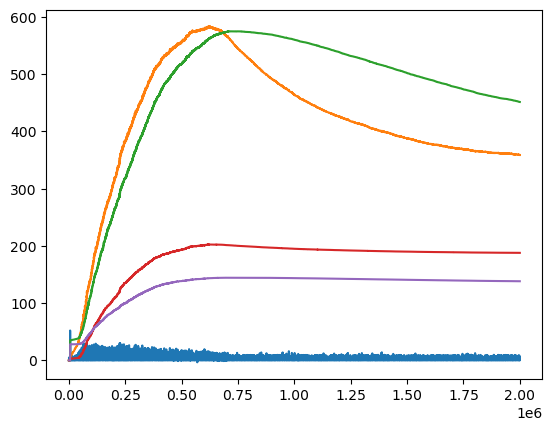

In [78]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [82]:
#Exact policy derived from VFA using exact PI
evalResultUnifApprox1 = rpiHomogVFA(N, resultUnifApprox[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001; nMax = 0, delScale = 1)

(22.1074331806382, [0.0 99.90009990009985 … 1898.3779970102175 2047.2762246334942; 100.89527650531835 200.79537640541804 … 2050.878051396026 0.0; … ; 1868.9252338666263 2029.9811513812992 … 0.0 0.0; 2029.9811513812992 0.0 … 0.0 0.0], 2821, [0 0 … 0 0; 0 0 … 0 0; … ; 13 12 … 0 0; 13 0 … 0 0])

In [79]:
#Policy derived from VFA in same way as gEval
evalResultUnifApprox2 = rpiHomogVFAApprox(N, resultUnifApprox[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001, resultUnifApprox[3]; nMax = 0, delScale = 1)

(21.988011112374103, [0.0 99.90009260311753 … 1898.3637208330515 2047.2643129750873; 99.90009260311753 199.8001852062352 … 2047.2643129750873 0.0; … ; 1898.530317891001 2087.440481494285 … 0.0 0.0; 2087.440481494285 0.0 … 0.0 0.0], 322, [0 0 … 0 0; 1 1 … 1 0; … ; 11 10 … 0 0; 11 0 … 0 0])

Different ways of evaluating the VFA are not equivalent.

In [83]:
evalResultUnifApprox1[4]

21×21 Matrix{Int64}:
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0   0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  

In [84]:
evalResultUnifApprox2[4]

21×21 Matrix{Int64}:
  0   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  1   1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0
  2   2  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0
  3   3  3  2  2  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
  4   4  3  3  2  2  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
  5   4  4  3  3  2  2  1  1  1  1  1  1  1  1  1  0  0  0  0  0
  5   5  4  4  3  3  2  1  1  1  1  1  1  1  1  0  0  0  0  0  0
  6   5  5  4  4  3  2  2  1  1  1  1  1  1  0  0  0  0  0  0  0
  6   6  5  5  4  3  3  2  2  1  1  1  1  0  0  0  0  0  0  0  0
  7   6  6  5  4  4  3  3  2  1  1  1  0  0  0  0  0  0  0  0  0
  7   7  6  5  5  4  4  3  2  2  1  0  0  0  0  0  0  0  0  0  0
  8   7  6  6  5  5  4  3  3  2  0  0  0  0  0  0  0  0  0  0  0
  8   7  7  6  6  5  4  4  3  0  0  0  0  0  0  0  0  0  0  0  0
  8   8  7  7  6  5  5  4  0  0  0  0  0  0  0  0  0  0  0  0  0
  9   8  8  7  6  6  5  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  9 

In [42]:
evalNMax = 1000000
gsUnifApprox = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultUnifApprox[1], features; printProgress = true, modCounter = 100000)
gsUnifApprox[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 39.80686724437455
 33.04762638584078
 25.06685432912306
 15.285806602439497
 14.81267442430803
 13.397235915893603
 13.397235915893603
 13.397235915893603
 13.397235915893603
 13.397235915893603
  ⋮
 20.776171153423594
 20.776132630614697
 20.77604274999996
 20.77597718528392
 20.77597197732539
 20.77596433123756
 20.77596433123756
 20.77596433123756
 20.77596433123756
 20.77596433123756
 20.77596433123756
 20.77596433123756

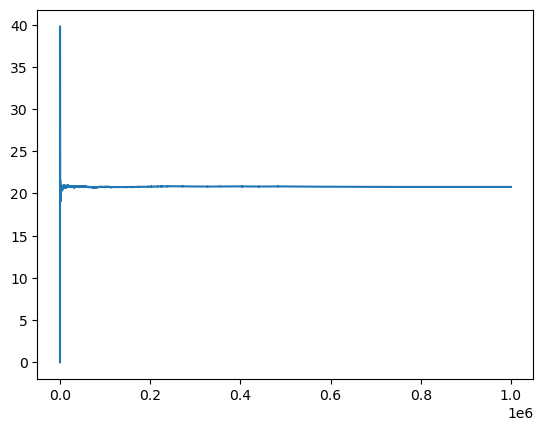

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000093EF33D0>

In [43]:
PyPlot.plot(gsUnifApprox[1])

Slight discrepency between simulation and exact PE, maybe because simulation never sees particularly bad states?

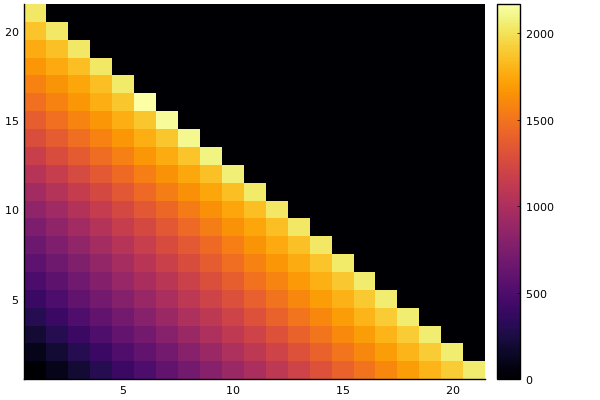

In [85]:
pyplot()
heatmap(evalResultUnifApprox1[2])

In [88]:
worst = []
for i in 1:21
    j = 22-i
    append!(worst,[evalResultUnifApprox1[2][i,j]])
end

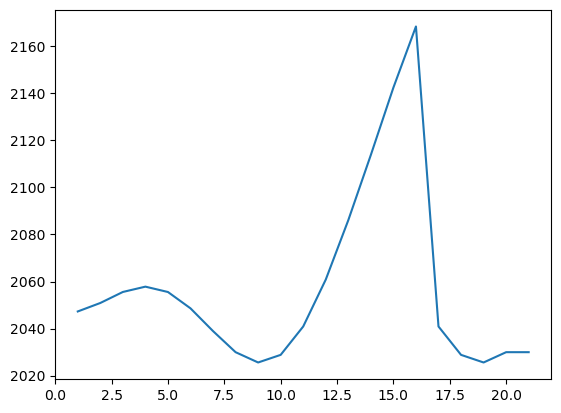

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000009F54DBE0>

In [89]:
PyPlot.plot(1:21,worst)

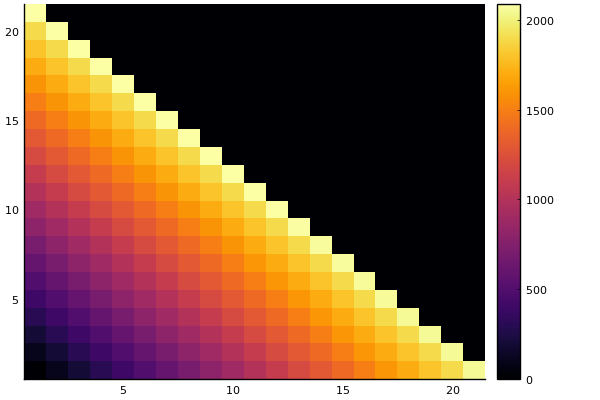

In [90]:
heatmap(evalResultUnifApprox2[2])

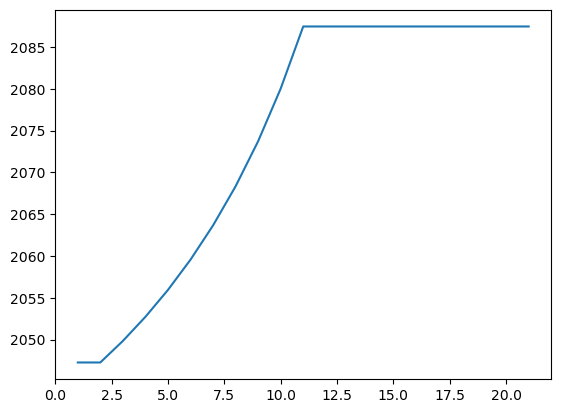

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A121B6A0>

In [91]:
worst = []
for i in 1:21
    j = 22-i
    append!(worst,[evalResultUnifApprox2[2][i,j]])
end
PyPlot.plot(1:21,worst)

## Test AVI-Unif-Full

In [93]:
nMax = 1000000 #algorithm seems far slower
stepsize = 1/10
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultUnifFull = approxValueIterationUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 50000)
println("Complete")

LoadError: InterruptException:

In [95]:
numPar = length(vParams)
paramHist = resultUnifFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

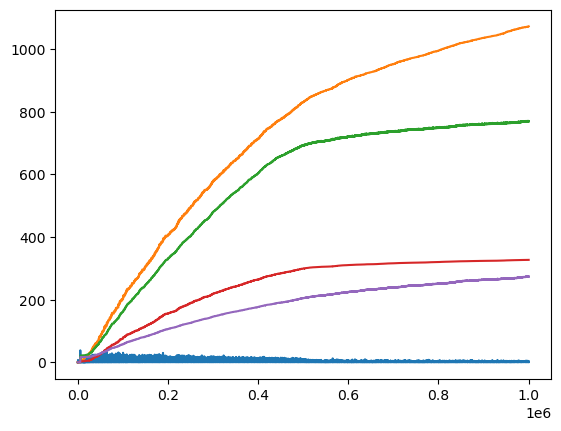

In [96]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [98]:
evalResultUnifFull1 = rpiHomogVFA(N, resultUnifFull[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001; nMax = 0, delScale = 1, forceActive = true)

(109.99071722421965, [0.0 99.90009990009985 … 1898.357181888204 2043.593380397146; 833.2559768684971 933.1560767685966 … 2779.327721743524 0.0; … ; 17157.416610833392 18147.42569348553 … 0.0 0.0; 18147.42569348553 0.0 … 0.0 0.0], 8411, [0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 1 0 … 0 0])

In [99]:
evalResultUnifFull2 = rpiHomogVFAApprox(N, resultUnifFull[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001, resultUnifFull[3]; nMax = 0, delScale = 1, forceActive = true)

(20.889439192971984, [0.0 99.90009990009986 … 1898.4132833218553 2047.3688114369165; 90.74532660809987 190.64542650820016 … 2047.3688114369165 0.0; … ; 1847.364071343691 2192.1416616331303 … 0.0 0.0; 2192.1416616331303 0.0 … 0.0 0.0], 5314, [0 0 … 0 0; 0 0 … 1 0; … ; 4 3 … 0 0; 4 0 … 0 0])

Seems like exact PI is the wrong way to interpret VFA value functions.

In [101]:
evalResultUnifFull1[4]

21×21 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  

In [102]:
evalResultUnifFull2[4]

21×21 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0
 0  0  1  1  1  1  1  1  0  1  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 2  1  1  1  1  1  0  0  0  0  0  

In [100]:
rpeFAHomog(N, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001; nMax = 0, delScale = 1, forceActive = true)

(21.98801085785556, [0.0 99.90009048212967 … 1898.363680534345 2047.2642705665598; 99.90009048212967 199.80018096425954 … 2047.2642705665598 0.0; … ; 1898.363680534345 2047.2642705665598 … 0.0 0.0; 2047.2642705665598 0.0 … 0.0 0.0], 317)

In [51]:
evalNMax = 1000000
gsUnifFull = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultUnifFull[1], features; printProgress = true, modCounter = 100000)
gsUnifFull[1]

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000


1000001-element Vector{Float64}:
  0.0
 10.0
 10.0
 14.081394275514285
 11.628664198287648
 11.628664198287648
 11.752522758801792
 11.376487019564657
 11.376487019564657
 11.632862527199924
 10.946804269426838
 10.946804269426838
 11.178780430875022
  ⋮
 20.808727371747278
 20.808790928287138
 20.808813921039643
 20.808842292658557
 20.80886447365051
 20.808885201067305
 20.80888684731786
 20.808925839273375
 20.80895847464485
 20.80896892126936
 20.808973270286423
 20.808977425374696

Exact DP says 20.88, simulation say 20.809, somewhat close.

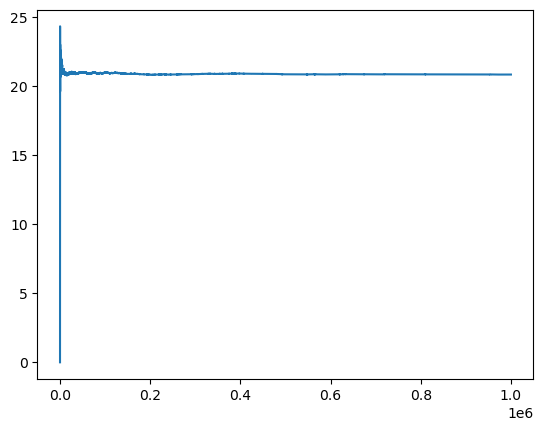

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000007FB61AF0>

In [52]:
PyPlot.plot(gsUnifFull[1])

In [59]:
evalNMax = 1000000
s = fill(3,N)
s[1] = 2
gsUnifFull2 = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultUnifFull[1], features; printProgress = true, modCounter = 50000)
gsUnifFull2[1]

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000


1000001-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975
 20.847858064378975

Closer to exact DP.

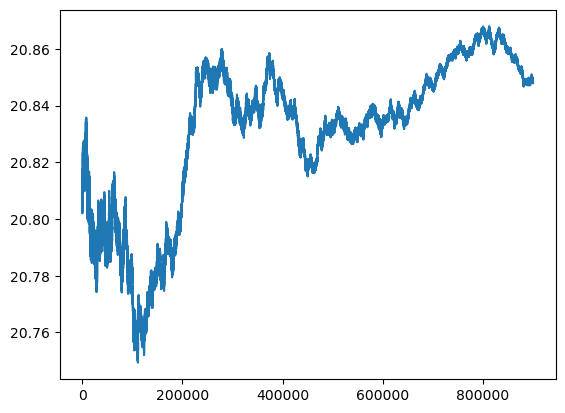

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000995CBBB0>

In [61]:
PyPlot.plot(gsUnifFull2[1][100000:evalNMax])

## Test AVI-Cont-Approx

In [107]:
nMax = 1000000 
stepsize = 1/100
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultContApprox = approxValueIterationContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 50000)
println("Complete")

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
550000
600000
650000
700000
750000
800000
850000
900000
950000
1000000
Complete


In [108]:
numPar = length(vParams)
paramHist = resultContApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

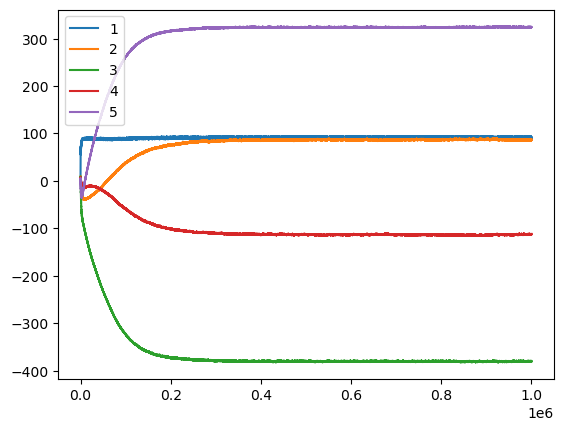

sys:1: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.


PyObject <matplotlib.legend.Legend object at 0x00000000A1536A00>

In [109]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end
legend()

In [110]:
evalResultContApprox = rpiHomogVFAApprox(N, resultContApprox[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001, resultContApprox[3]; nMax = 0, delScale = 1, forceActive = true)

(20.7631576387449, [0.0 99.90009990010239 … 1900.1760760933491 2049.1379191434103; 89.69298032287418 189.59308022299766 … 2049.1379191434103 0.0; … ; 1901.5151679585535 2123.549846834229 … 0.0 0.0; 2123.549846834229 0.0 … 0.0 0.0], 6773, [0 0 … 0 0; 0 0 … 1 0; … ; 7 7 … 0 0; 8 0 … 0 0])

In [111]:
evalResultContApprox[4]

21×21 Matrix{Int64}:
 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0
 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0
 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0
 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0
 0  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0
 0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0
 0  0  0  1  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0
 0  0  0  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0
 0  0  1  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0
 0  0  1  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0
 0  0  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  1  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  1  1  1  2  2  0  0  0  0  0  0  0  0  0  0  0  0  0  0
 0  1  2  2  3  3  0  0  0  0  0  

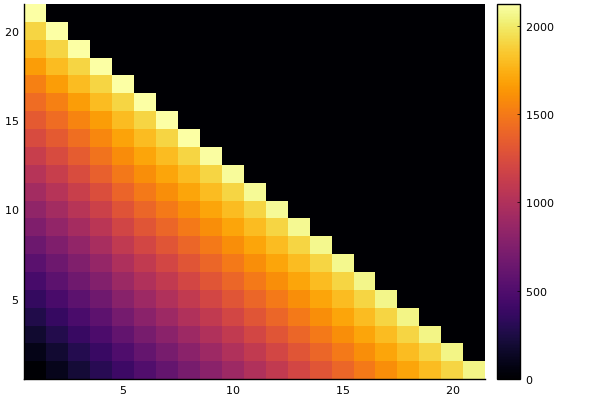

In [112]:
heatmap(evalResultContApprox[2])

In [116]:
evalNMax = 200000
s = fill(3,N)
s[1] = 2
gs = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContApprox[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gs[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 20.811634742236865
 20.811652682051687
 20.81186010766786
 20.811874983166714
 20.81199740275678
 20.812177594377108
 20.812310718439484
 20.812566040924374
 20.812597397400946
 20.812797250839704
 20.812876721670378
 20.812796865081836

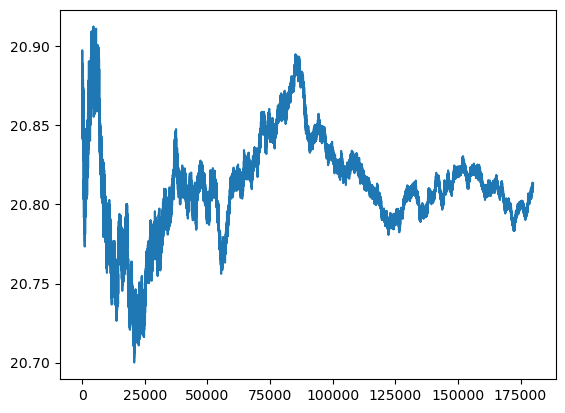

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000009A77BE80>

In [117]:
PyPlot.plot(gs[1][20000:evalNMax])

True evaluation of 20.76 falls within this range

## Test AVI-Cont-Full

In [127]:
nMax = 300000 
stepsize = 1/100
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultContFull = approxValueIterationContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 50000)
println("Complete")

50000
100000
150000
200000
250000
300000
Complete


In [128]:
numPar = length(vParams)
paramHist = resultContFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

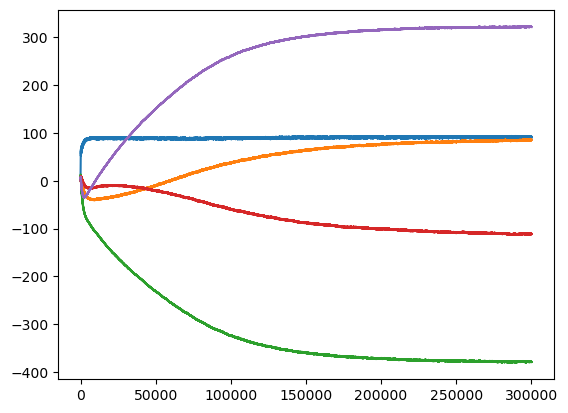

In [129]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [130]:
evalResultContApprox = rpiHomogVFAApprox(N, resultContFull[1], features, alpha_d[1], alpha_r[1], beta, tau, c0[1], c1, r[1], 0.00001, resultContApprox[3]; nMax = 0, delScale = 1, forceActive = true)

(20.7631576387449, [0.0 99.90009990010239 … 1900.1760760933491 2049.1379191434103; 89.69298032287418 189.59308022299766 … 2049.1379191434103 0.0; … ; 1901.5151679585535 2123.549846834229 … 0.0 0.0; 2123.549846834229 0.0 … 0.0 0.0], 6773, [0 0 … 0 0; 0 0 … 1 0; … ; 7 7 … 0 0; 8 0 … 0 0])

In [131]:
evalNMax = 200000
s = fill(3,N)
s[1] = 2
gsContFull = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContFull[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContFull[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  ⋮
 20.833387251669865
 20.83382022544705
 20.833943784554073
 20.83396288306771
 20.83401453005326
 20.834160889066386
 20.83416589993602
 20.834476455192277
 20.83456945813685
 20.83474207135328
 20.834997931457664
 20.835316861457706

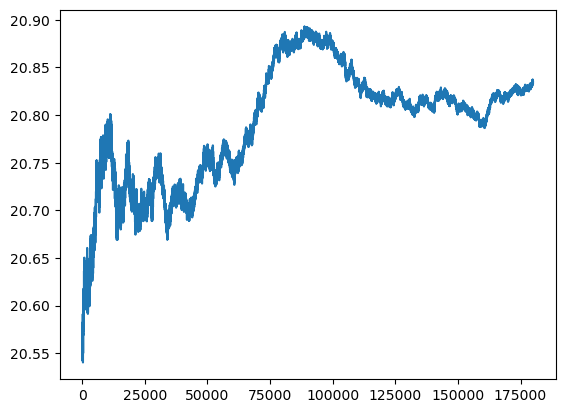

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000009A868DF0>

In [135]:
PyPlot.plot(gsContFull[1][20000:evalNMax])

True value falls in range.

# N = 5 Inhomogeneous test

## Test AVI-Unif-Approx

In [211]:
#Example 2 from Masters inhomog section
function tau(n)
    return n
end

N=5
alpha_d = [0.01*i for i in 1:N]
alpha_r = [0.001*i for i in 1:N] 
beta=10.0
c0=[1.0*i for i in 1:5] 
c1=100.0
r=[100.0*i for i in 1:5] 
repIndicators = [s -> (s[i]==2)*(s[j]==2) for i in 1:N for j in i:N]
damIndicators = [s -> (s[i]==3)*(s[j]==3) for i in 1:N for j in i:N]
indicators = [repIndicators;damIndicators]
features = indicators
vParams = zeros(length(features) + 1)
nMax = 1000000
stepsize = 1/500
resultUnifApprox = approxValueIterationUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


In [212]:
numPar = length(vParams)
paramHist = resultUnifApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

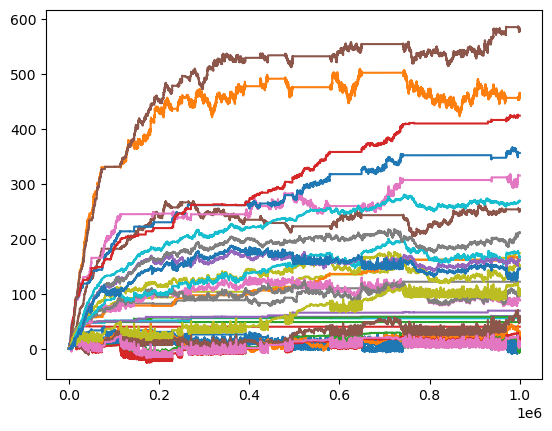

In [213]:
for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [217]:
evalResultUnifApprox1 = rpiVFA(N, resultUnifApprox[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.1; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(73.50398871101464, Dict{Any, Any}([2, 1, 3, 1, 1] => -3165.98657656263, [2, 3, 1, 2, 3] => 142542.88530472422, [2, 1, 2, 2, 2] => 2131.168113920589, [3, 2, 1, 3, 3] => 119182.98321936156, [3, 2, 2, 2, 1] => 22314.37472197477, [3, 2, 2, 1, 3] => 150237.21179630203, [1, 2, 3, 2, 3] => 147446.22601433186, [1, 2, 1, 1, 2] => 688.6504653114719, [1, 2, 2, 3, 1] => 153.904188138122, [3, 1, 3, 3, 3] => 158492.57603614658…), 10000)

In [219]:
evalResultUnifApprox2 = rpiVFAInstant(N, resultUnifApprox[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, resultUnifApprox[3]; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(73.71206153688159, Dict{Any, Any}([2, 1, 3, 1, 1] => -3132.8140631720757, [2, 3, 1, 2, 3] => 141202.160825799, [2, 1, 2, 2, 2] => 2123.7706964696363, [3, 2, 1, 3, 3] => 118083.08999665342, [3, 2, 2, 2, 1] => 22125.091787484147, [3, 2, 2, 1, 3] => 148840.43710421692, [1, 2, 3, 2, 3] => 146045.853145618, [1, 2, 1, 1, 2] => 688.7652499155158, [1, 2, 2, 3, 1] => 160.3630368997181, [3, 1, 3, 3, 3] => 157058.0841355178…), 10000)

In [220]:
evalNMax = 200000
s = fill(3,N)
gsUnifApprox = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultUnifApprox[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsUnifApprox[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
    0.0
    0.0
    0.0
 1899.9999999999998
  596.375035428386
  596.375035428386
 1248.7836107789046
  832.068961387821
  488.0830326804602
  486.0953090331167
  486.0953090331167
  486.0953090331167
  548.5879061146645
    ⋮
   61.09823319741527
   61.09861984705316
   61.09865382075132
   61.09865382075132
   61.098741754017155
   61.09987466938506
   61.09942569838866
   61.09942569838866
   61.09955550234583
   61.09955550234583
   61.09980314824894
   61.099869701271466

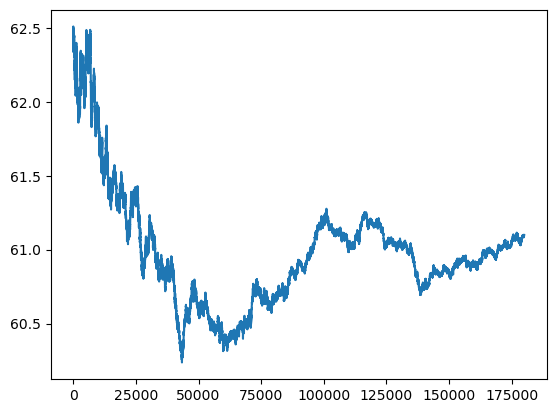

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x000000006615D370>

In [221]:
PyPlot.plot(gsUnifApprox[1][20000:evalNMax])

The hell?

## AVI-Unif-Full

In [229]:
nMax = 500000
stepsize = 1/100
resultUnifFull = approxValueIterationUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 50000)
println("Complete")

50000
100000
150000
200000
250000
300000
350000
400000
450000
500000
Complete


Table Made

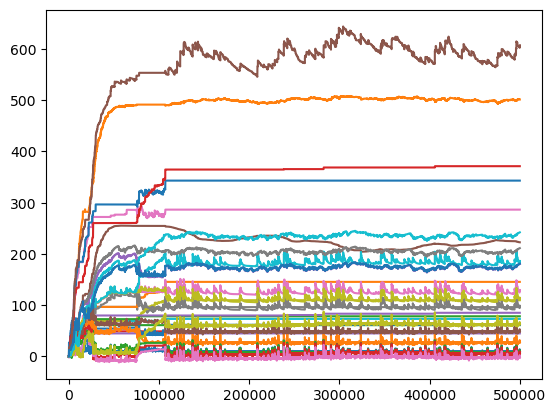

In [230]:
numPar = length(vParams)
paramHist = resultUnifFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

print("Table Made")

for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [232]:
evalResultUnifFull = rpiVFAInstant(N, resultUnifFull[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, resultUnifFull[3]; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000


(63.10602893448887, Dict{Any, Any}([2, 1, 3, 1, 1] => 203.23765296778035, [2, 3, 1, 2, 3] => 2455.9738702054315, [2, 1, 2, 2, 2] => 1326.9298207271113, [3, 2, 1, 3, 3] => 2879.1387846441107, [3, 2, 2, 2, 1] => 1732.8986207380142, [3, 2, 2, 1, 3] => 2884.811341900085, [1, 2, 3, 2, 3] => 2584.195397133573, [1, 2, 1, 1, 2] => 700.9808445907589, [1, 2, 2, 3, 1] => 586.1588954596148, [3, 1, 3, 3, 3] => 2831.487894909182…), 7225)

In [234]:
evalNMax = 200000
s = fill(3,N)
gsUnifFull = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultUnifFull[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsUnifFull[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
    0.0
    0.0
    0.0
 1600.0
 1122.4979979158616
 1349.1782383432771
  250.5871320751061
  250.5871320751061
  250.5871320751061
  257.5404146541724
  262.86014750770664
  243.2634893608108
  243.2634893608108
    ⋮
   60.100660685274946
   60.100693473354944
   60.100405929439624
   60.100405929439624
   60.10045444638353
   60.100351573665236
   60.100351573665236
   60.100353169413246
   60.10024111893694
   60.10024111893694
   60.10025998407768
   60.098166703419196

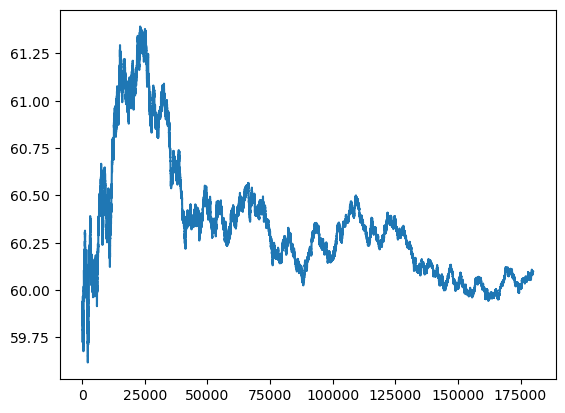

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A14AE430>

In [236]:
PyPlot.plot(gsUnifFull[1][20000:evalNMax])

In [242]:
inhomogFA = rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

(29.74392599562579, Dict{Any, Any}([2, 1, 3, 1, 1] => 444.17968752327545, [2, 3, 1, 2, 3] => 1284.1217306637188, [2, 1, 2, 2, 2] => 1349.5987674795992, [3, 2, 1, 3, 3] => 1284.1217306637188, [3, 2, 2, 2, 1] => 1141.9564335161244, [3, 2, 2, 1, 3] => 1214.2241474161458, [1, 2, 3, 2, 3] => 1404.1561427878619, [1, 2, 1, 1, 2] => 700.1780995521124, [1, 2, 2, 3, 1] => 903.1023690827969, [3, 1, 3, 3, 3] => 1349.5987674795992…), 105)

Both uniform algorithms now seem to be performing terribly on the inhomogeneous problem. Perhaps due to change in action selection?

## AVI-Cont-Approx

In [255]:
nMax = 1000000
stepsize = 1/500
resultContApprox = approxValueIterationContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
Complete


Table Made

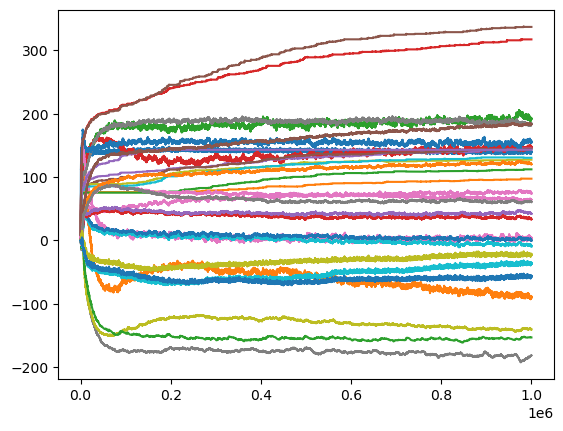

In [256]:
numPar = length(vParams)
paramHist = resultContApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

print("Table Made")

for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [260]:
evalResultContApprox = rpiVFAInstant(N, resultContApprox[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, resultUnifFull[3]; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(26.72636056149432, Dict{Any, Any}([2, 1, 3, 1, 1] => 525.3905267576722, [2, 3, 1, 2, 3] => 589.9279010095347, [2, 1, 2, 2, 2] => 1374.0327340542099, [3, 2, 1, 3, 3] => 376.6249333740104, [3, 2, 2, 2, 1] => 1166.3830833386774, [3, 2, 2, 1, 3] => 518.6386765482981, [1, 2, 3, 2, 3] => 666.487753267492, [1, 2, 1, 1, 2] => 702.4008138729604, [1, 2, 2, 3, 1] => 600.9109907958297, [3, 1, 3, 3, 3] => 435.1660783952025…), 10000)

In [272]:
evalResultContApprox = rpiVFAInstant(N, resultContApprox[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, 29.621278815999595; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

(29.621278815999595, Dict{Any, Any}([2, 1, 3, 1, 1] => 609.5743249542163, [2, 3, 1, 2, 3] => 1067.0209444536754, [2, 1, 2, 2, 2] => 1396.3933527249517, [3, 2, 1, 3, 3] => 513.8440397548845, [3, 2, 2, 2, 1] => 1240.261474014766, [3, 2, 2, 1, 3] => 775.2863055950702, [1, 2, 3, 2, 3] => 965.0301502566969, [1, 2, 1, 1, 2] => 702.5083013865742, [1, 2, 2, 3, 1] => 513.6958684805348, [3, 1, 3, 3, 3] => 445.4941330142737…), 310)

Train slightly more, seems close to convergence.

In [258]:
nMax = 500000
stepsize = 1/500
resultContApprox2 = approxValueIterationContApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, resultContApprox[1], features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
Complete


Table Made

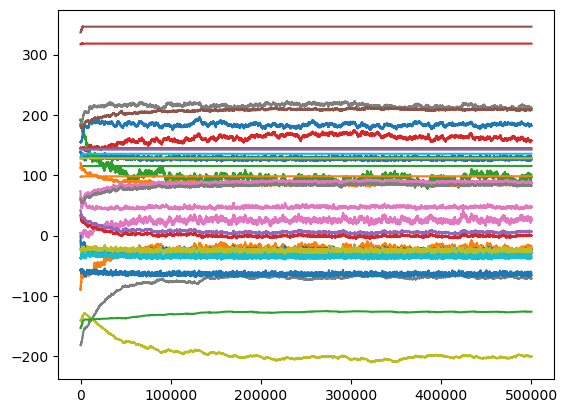

In [259]:
numPar = length(vParams)
paramHist = resultContApprox2[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

print("Table Made")

for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [276]:
evalResultContApprox2 = rpiVFAInstant(N, resultContApprox2[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, resultContApprox[3]; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(260.8881478512747, Dict{Any, Any}([2, 1, 3, 1, 1] => 27433.28251606506, [2, 3, 1, 2, 3] => 12537.1902623624, [2, 1, 2, 2, 2] => 9888.176845557256, [3, 2, 1, 3, 3] => -43626.577492793775, [3, 2, 2, 2, 1] => 44025.7398720375, [3, 2, 2, 1, 3] => 2762.167304285412, [1, 2, 3, 2, 3] => -10049.861970955631, [1, 2, 1, 1, 2] => 6381.602739328424, [1, 2, 2, 3, 1] => -42320.786135205584, [3, 1, 3, 3, 3] => 182397.42644632625…), 10000)

In [308]:
evalResultContApprox2 = rpiVFAInstant(N, resultContApprox2[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, 23; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

(31.329186437853636, Dict{Any, Any}([2, 1, 3, 1, 1] => 706.9902233132945, [2, 3, 1, 2, 3] => 1276.65820067629, [2, 1, 2, 2, 2] => 1448.435488527853, [3, 2, 1, 3, 3] => 995.3080448524197, [3, 2, 2, 2, 1] => 1598.7400459187045, [3, 2, 2, 1, 3] => 1218.2670559704502, [1, 2, 3, 2, 3] => 1151.6837096546508, [1, 2, 1, 1, 2] => 737.9271653356867, [1, 2, 2, 3, 1] => 569.1899281746836, [3, 1, 3, 3, 3] => 2229.366264403393…), 338)

In [262]:
evalNMax = 200000
s = fill(3,N)
gsContApprox = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContApprox[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContApprox[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
 1600.0
 1176.602180005062
  841.1223582208258
  585.291058527317
  287.6280783132094
  221.937774190147
  221.937774190147
  221.937774190147
  221.937774190147
    ⋮
   67.55782360479003
   67.5578295392442
   67.55640743520672
   67.55635354059905
   67.55623317460511
   67.55623317460511
   67.55623317460511
   67.55623317460511
   67.5577600728246
   67.5581967747368
   67.558887851981
   67.558887851981

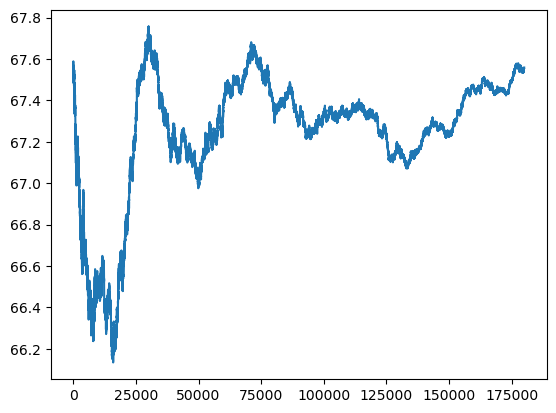

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x0000000066054F70>

In [263]:
PyPlot.plot(gsContApprox[1][20000:evalNMax])

In [264]:
evalNMax = 200000
s = fill(3,N)
gsContApprox2 = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContApprox2[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContApprox2[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
 1600.0
 1079.1494213544954
  666.2661432512971
  102.91566599735802
   89.16336498746246
   72.6798458980616
   72.6798458980616
   72.6798458980616
   72.6798458980616
    ⋮
   68.32743175326466
   68.32743175326466
   68.3297863199463
   68.33060848530396
   68.33066037693159
   68.33047773328731
   68.32984145314862
   68.32980066686447
   68.32980066686447
   68.32980066686447
   68.32980066686447
   68.3302844328166

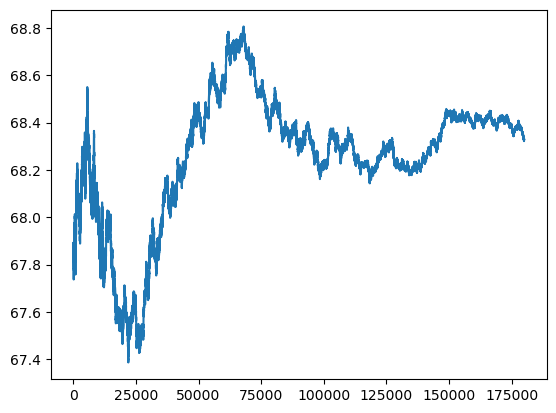

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000A91AF4F0>

In [266]:
PyPlot.plot(gsContApprox2[1][20000:evalNMax])

It *may* be the case that initial high estimates of g change the course of the policy, so we instead try starting from s0 again.

In [277]:
evalNMax = 200000
gsContApproxS0 = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContApprox[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContApproxS0[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000

200001-element Vector{Float64}:
  0.0
 10.0
 10.0
 27.02145335628745
 13.718917637446623
 13.718917637446623
 18.17907989367126
 14.449357144352545
 13.84113645046096
 13.84113645046096
 16.43054004946179
 16.19770637809913
 16.19770637809913
  ⋮
 27.98737912468234
 27.987248142554478
 27.987248142554478
 27.987293733708242
 27.98723554343732
 27.98723554343732
 27.987236074358663
 27.987236074358663
 27.987435557679472
 27.98795256279496
 27.98776012876467
 27.98776012876467

In [278]:
evalNMax = 200000
gsContApprox2S0 = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContApprox2[1], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContApprox2S0[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
  0.0
 10.0
 10.0
 14.583678719181359
 13.13742838663995
 13.13742838663995
 27.49389128364228
 27.27715823632009
 24.928309234899743
 24.928309234899743
 26.66775097026006
 26.66775097026006
 27.635860357665237
  ⋮
 28.14429105011642
 28.14429105011642
 28.144562814683734
 28.144526358900368
 28.144526358900368
 28.144621645858873
 28.144444720842078
 28.144444720842078
 28.144502021807973
 28.144502021807973
 28.14461407899116
 28.144898872466023

Estimate of g has massive impact on performance of the policy. Overestimating g is especially bad.

## AVI-Cont-Full

In [294]:
nMax = 500000
stepsize = 1/100
resultContFull = approxValueIterationContFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
Complete


Table Made

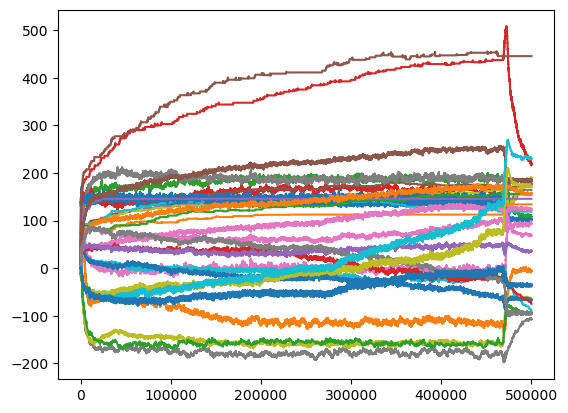

In [295]:
numPar = length(vParams)
paramHist = resultContFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

print("Table Made")

for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

In [297]:
evalResultContFull400000 = rpiVFAInstant(N, resultContFull[2][400000], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, 26.700750626491143; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(26.70075074484795, Dict{Any, Any}([2, 1, 3, 1, 1] => 451.9664813974602, [2, 3, 1, 2, 3] => 971.5870424995977, [2, 1, 2, 2, 2] => 1359.4468791879176, [3, 2, 1, 3, 3] => 755.1221157570292, [3, 2, 2, 2, 1] => 1196.241672271145, [3, 2, 2, 1, 3] => 898.8125199981583, [1, 2, 3, 2, 3] => 1058.8449767142858, [1, 2, 1, 1, 2] => 703.4491806511763, [1, 2, 2, 3, 1] => 654.8911831620157, [3, 1, 3, 3, 3] => 822.648943085627…), 10000)

In [298]:
evalResultContFullEnd = rpiVFAInstant(N, resultContFull[1], features, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001, 0; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000
5000
6000
7000
8000
9000


(431.2456386650791, Dict{Any, Any}([2, 1, 3, 1, 1] => 12724.269822151413, [2, 3, 1, 2, 3] => 17403.23375352653, [2, 1, 2, 2, 2] => 4372.056205476877, [3, 2, 1, 3, 3] => 28549.555495456392, [3, 2, 2, 2, 1] => 11565.080253232536, [3, 2, 2, 1, 3] => 17916.966443976296, [1, 2, 3, 2, 3] => 73896.62866882126, [1, 2, 1, 1, 2] => 1207.4530851011637, [1, 2, 2, 3, 1] => 37783.87152792723, [3, 1, 3, 3, 3] => 77928.7162461189…), 10000)

We'll take the 400000th estimate!

In [299]:
evalNMax = 200000
s = fill(3,N)
gsContFullFromWorst = gEvaluationContFromS(s,N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContFull[2][400000], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContFullFromWorst[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
    0.0
    0.0
    0.0
    0.0
 1600.0000000000002
  653.4323071164368
  625.7428999635503
  150.82526840904097
  133.43427189625515
  104.12946109883272
  104.12946109883272
  104.12946109883272
  104.12946109883272
    ⋮
   67.999005351908
   67.99854322164308
   67.99854322164308
   67.99854322164308
   67.99854322164308
   67.99996154874557
   68.00077934810375
   68.00117552756453
   68.00117552756453
   68.00118833331992
   68.00126228734818
   68.00086265908678

In [300]:
evalNMax = 200000
gsContFullFromBest = gEvaluationCont(N,alpha_d, alpha_r, beta, tau, c0, c1, r, evalNMax, resultContFull[2][400000], features; printProgress = true, modCounter = 10000, forceActive = true)
gsContFullFromBest[1]

10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
180000
190000
200000


200001-element Vector{Float64}:
  0.0
 10.0
 10.0
 12.808982897745866
 12.24466940298186
 12.24466940298186
 18.539378465831454
 17.786046568511672
 17.786046568511672
 20.981854151641613
 19.228718485804233
 19.228718485804233
 24.40089045906159
  ⋮
 27.71805992900035
 27.71763400830434
 27.71763400830434
 27.71765468057329
 27.717123521402733
 27.717123521402733
 27.71724059219723
 27.716967643120988
 27.716967643120988
 27.717023722729344
 27.716987341097926
 27.716987341097926

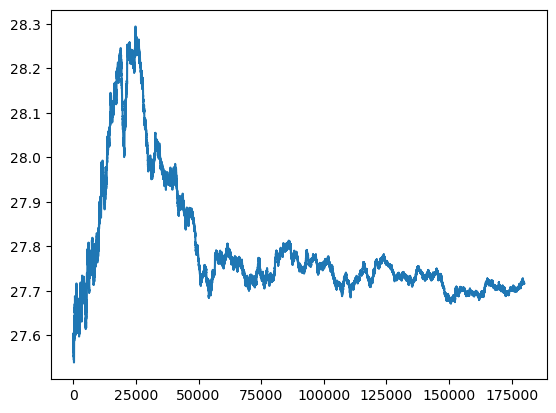

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x00000000AAB20070>

In [301]:
PyPlot.plot(gsContFullFromBest[1][20000:evalNMax])

True value of 26.7 falls outside simulated range.

In [303]:
rvi(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 10000, delScale = 1, printProgress = true, modCounter = 1000)

1000
2000
3000
4000


(26.34931732766819, Dict{Any, Any}([2, 1, 3, 1, 1] => 382.61671901866714, [2, 3, 1, 2, 3] => 890.0978676940146, [2, 1, 2, 2, 2] => 1346.1014623466888, [3, 2, 1, 3, 3] => 691.2333175770024, [3, 2, 2, 2, 1] => 1088.2874477827652, [3, 2, 2, 1, 3] => 805.1720343676764, [1, 2, 3, 2, 3] => 999.13183939027, [1, 2, 1, 1, 2] => 699.3023436958009, [1, 2, 2, 3, 1] => 647.2785520472725, [3, 1, 3, 3, 3] => 754.3182236565899…), 4101, Dict{Any, Any}([2, 1, 3, 1, 1] => [0, 0, 0, 0, 0], [2, 3, 1, 2, 3] => [0, 0, 0, 0, 0], [2, 1, 2, 2, 2] => [0, 0, 0, 0, 0], [3, 2, 1, 3, 3] => [0, 0, 0, 0, 0], [3, 2, 2, 2, 1] => [0, 0, 0, 0, 0], [3, 2, 2, 1, 3] => [0, 0, 0, 0, 0], [1, 2, 3, 2, 3] => [0, 0, 0, 0, 0], [1, 2, 1, 1, 2] => [0, 0, 0, 0, 0], [1, 2, 2, 3, 1] => [0, 0, 0, 0, 0], [3, 1, 3, 3, 3] => [0, 0, 0, 0, 0]…))

# Exact PI on passive policy for inhomogeneous problem

In [311]:
passiveResult = rpePassive(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

1000


(999.9999361396826, Dict{Any, Any}([2, 1, 3, 1, 1] => 3097.8057664588982, [2, 3, 1, 2, 3] => 6856.198077497204, [2, 1, 2, 2, 2] => 1284.5809321196512, [3, 2, 1, 3, 3] => 13733.18320308928, [3, 2, 2, 2, 1] => 10337.943206366646, [3, 2, 2, 1, 3] => 11728.341554826426, [1, 2, 3, 2, 3] => 5337.710042331976, [1, 2, 1, 1, 2] => 696.6510411343925, [1, 2, 2, 3, 1] => 2692.6211936147133, [3, 1, 3, 3, 3] => 16689.319632997165…), 1127)

In [316]:
PIResult = rpiExact(N, passiveResult[2], alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

(29.743926390992176, Dict{Any, Any}([2, 1, 3, 1, 1] => 444.1796932003067, [2, 3, 1, 2, 3] => 1286.1993399051719, [2, 1, 2, 2, 2] => 1349.5987790347947, [3, 2, 1, 3, 3] => 1290.8019399407392, [3, 2, 2, 2, 1] => 1141.9564443103002, [3, 2, 2, 1, 3] => 1217.0582035280627, [1, 2, 3, 2, 3] => 1404.6305291399585, [1, 2, 1, 1, 2] => 700.1781047013856, [1, 2, 2, 3, 1] => 903.102375757713, [3, 1, 3, 3, 3] => 1359.8090373649238…), 107, Dict{Any, Any}([2, 1, 3, 1, 1] => [0, 0, 1, 0, 0], [2, 3, 1, 2, 3] => [0, 1, 0, 0, 0], [2, 1, 2, 2, 2] => [0, 0, 0, 0, 0], [3, 2, 1, 3, 3] => [1, 0, 0, 0, 0], [3, 2, 2, 2, 1] => [1, 0, 0, 0, 0], [3, 2, 2, 1, 3] => [1, 0, 0, 0, 0], [1, 2, 3, 2, 3] => [0, 0, 1, 0, 0], [1, 2, 1, 1, 2] => [0, 0, 0, 0, 0], [1, 2, 2, 3, 1] => [0, 0, 0, 1, 0], [3, 1, 3, 3, 3] => [1, 0, 0, 0, 0]…))

In [315]:
FAResult = rpeFA(N, alpha_d, alpha_r, beta, tau, c0, c1, r, 0.00001; nMax = 0, delScale = 1, printProgress = true, modCounter = 1000)

(29.74392599562579, Dict{Any, Any}([2, 1, 3, 1, 1] => 444.17968752327545, [2, 3, 1, 2, 3] => 1284.1217306637188, [2, 1, 2, 2, 2] => 1349.5987674795992, [3, 2, 1, 3, 3] => 1284.1217306637188, [3, 2, 2, 2, 1] => 1141.9564335161244, [3, 2, 2, 1, 3] => 1214.2241474161458, [1, 2, 3, 2, 3] => 1404.1561427878619, [1, 2, 1, 1, 2] => 700.1780995521124, [1, 2, 2, 3, 1] => 903.1023690827969, [3, 1, 3, 3, 3] => 1349.5987674795992…), 105)

In [317]:
PIResult[4]

Dict{Any, Any} with 243 entries:
  [2, 1, 3, 1, 1] => [0, 0, 1, 0, 0]
  [2, 3, 1, 2, 3] => [0, 1, 0, 0, 0]
  [2, 1, 2, 2, 2] => [0, 0, 0, 0, 0]
  [3, 2, 1, 3, 3] => [1, 0, 0, 0, 0]
  [3, 2, 2, 2, 1] => [1, 0, 0, 0, 0]
  [3, 2, 2, 1, 3] => [1, 0, 0, 0, 0]
  [1, 2, 3, 2, 3] => [0, 0, 1, 0, 0]
  [1, 2, 1, 1, 2] => [0, 0, 0, 0, 0]
  [1, 2, 2, 3, 1] => [0, 0, 0, 1, 0]
  [3, 1, 3, 3, 3] => [1, 0, 0, 0, 0]
  [3, 3, 1, 1, 1] => [1, 0, 0, 0, 0]
  [3, 3, 3, 3, 2] => [1, 0, 0, 0, 0]
  [1, 1, 3, 1, 2] => [0, 0, 1, 0, 0]
  [2, 2, 3, 2, 2] => [0, 0, 1, 0, 0]
  [2, 3, 3, 3, 1] => [0, 1, 0, 0, 0]
  [3, 2, 1, 2, 3] => [1, 0, 0, 0, 0]
  [1, 2, 1, 3, 3] => [0, 0, 0, 1, 0]
  [1, 2, 2, 2, 1] => [0, 0, 0, 0, 0]
  [1, 2, 2, 1, 3] => [0, 0, 0, 0, 1]
  [3, 1, 3, 2, 3] => [1, 0, 0, 0, 0]
  [3, 1, 1, 1, 2] => [1, 0, 0, 0, 0]
  [3, 3, 3, 2, 2] => [1, 0, 0, 0, 0]
  [3, 1, 2, 3, 1] => [1, 0, 0, 0, 0]
  [1, 1, 3, 3, 3] => [0, 0, 1, 0, 0]
  [1, 3, 1, 1, 1] => [0, 1, 0, 0, 0]
  ⋮               => ⋮

Seems like PI on passive policy gives fully active policy 

# APE-FA N = 10 tests

## APE-Unif-Approx

In [81]:
Random.seed!(12345)
function tau(n)
    return n
end

#define features
function numRep(s)
    n = length(s)
    return sum(s[i] == 2 for i in 1:n)/n
end

function numDamage(s)
    n = length(s)
    return sum(s[i] == 3 for i in 1:n)/n
end

function numRepSq(s)
    return numRep(s)^2
end

function numDamageSq(s)
    return numDamage(s)^2
end

N=20
alpha_d = [0.01 for i in 1:N]
alpha_r = [0.001 for i in 1:N] 
beta=10.0
c0=[1.0 for i in 1:N] 
c1=100.0
r=[100.0 for i in 1:N]
nMax = 10000000
stepsize = 1/50
features = [numRep, numDamage, numRepSq, numDamageSq]
vParams = zeros(length(features) + 1)
resultUnifApprox = apeFAUnifApprox(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 1000000)
println("Complete")

1000000
2000000
3000000
4000000
5000000
6000000
7000000
8000000
9000000
10000000
Complete


Table Made

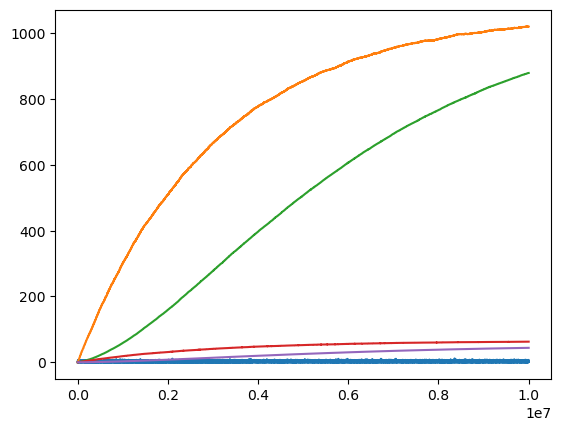

In [82]:
numPar = length(vParams)
paramHist = resultUnifApprox[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

print("Table Made")

for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end

## AVI-Unif-Full

In [77]:
nMax = 2000000
stepsize = 1/10
resultUnifFull = apeFAUnifFull(N,alpha_d, alpha_r, beta, tau, c0, c1, r, nMax, stepsize, vParams, features; printProgress = true, modCounter = 100000)
println("Complete")

100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000
2000000
Complete


Table Made

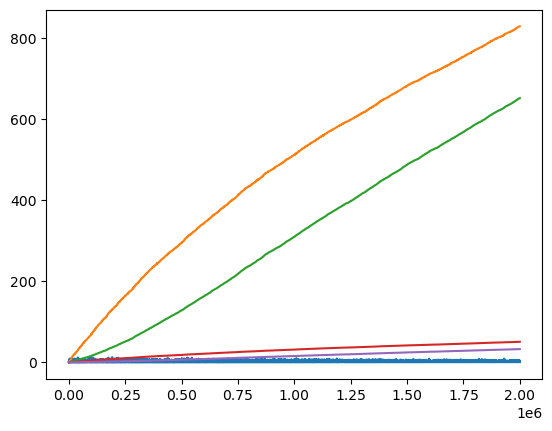

In [78]:
numPar = length(vParams)
paramHist = resultUnifFull[2]
paramHistT = Dict()
for i in 1:numPar
    paramHistT[i] = zeros(nMax)
end
for i in 1:numPar
    for j in 1:nMax
        paramHistT[i][j] = paramHist[j][i]
    end
end

print("Table Made")

for i in 1:numPar
    PyPlot.plot(paramHistT[i], label = i)
end